Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

1: Total tims is  60.59 s
2: Total numb steps is  64


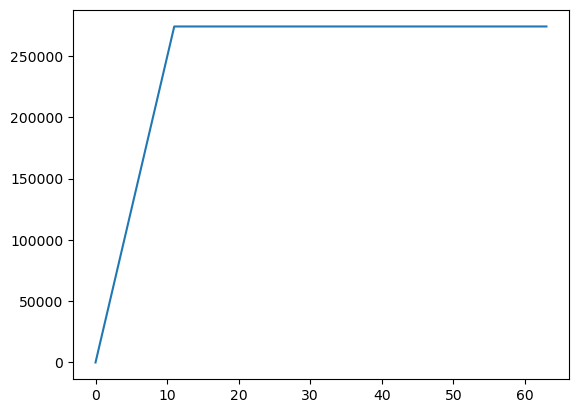

In [1]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    functionspace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions
from brake_disc_functions import *

# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 10
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 2200
v_vehicle = 160
c_acc = 1

# calling local functions to get all parameters
(
    dt,
    P,
    g,
    num_steps,
    h,
    radiation,
    v_angular,
    Ti,
    Tm,
    S_rub_circle,
    t,
    rho,
    c,
    k,
    t_brake,
    S_total,
) = vehicle_initial(angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)
plt.plot(P)

In [2]:
print(k)
print(h)

0.048
7.75e-05


## 2: Mesh

In [3]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-10.msh' exists, start creat now:
Info    : Reading 'm-3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading 'm-3-10.msh'



## 3: Setup 


In [4]:
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition

x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [5]:
print(dt[0])

0.39741147067910887


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = ufl.TrialFunction(V)
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)


F = (
    - (rho * c) / dt[0] * inner(u, v) * dx
    - h * (u_n - Tm) * v * ds(200)
    - radiation * (u_n**4 - Tm**4) * v * ds(200)  
    - k * inner(grad(u_n), grad(v)) * dx
    + inner(f, v) * dx
    + inner(u_n, v) * dx
    )

## inner is for vector or tensor, v is first order lagrange element, so it is a saclar field.

for i in list(range(1, 19)):
    #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
    F +=  -inner(g[0], v) * ds(10 * i) + h * (u_n - Tm) * v * ds(10 * i) + radiation * (u_n**4 - Tm**4) * v *ds(10 * i)

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)



2024-05-22 15:59:49.824 (  12.854s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 15:59:49.899 (  12.922s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 15:59:49.917 (  12.941s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.08025 (tol = 1e-10) r (rel) = 1.58459e-06(tol = 1e-06)
2024-05-22 15:59:49.934 (  12.957s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 15:59:49.961 (  12.985s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.19772e-06 (tol = 1e-10) r (rel) = 7.62445e-12(tol = 1e-06)
2024-05-22 15:59:49.962 (  12.985s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    ####### new
    F = (
    - (rho * c) / dt[i] * inner(u, v) * dx
    - h * (u_n - Tm) * v * ds(200)
    - radiation * (u_n**4 - Tm**4) * v * ds(200)  
    - k * inner(grad(u_n), grad(v)) * dx
    + inner(f, v) * dx
    + inner(u_n, v) * dx
    )

    ## inner is for vector or tensor, v is first order lagrange element, so it is a saclar field.

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
        #F +=   inner(g[i], v) * ds(10* j) + h* (u_n - Tm)*v* ds(10* j) + radiation*(u_n**4 -Tm**4) *v*ds(10* j)
        F +=    h* (u_n - Tm)*v* ds(10* j) + radiation*(u_n**4 -Tm**4) *v*ds(10* j)


    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 2200 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-05-22 15:59:53.201 (  16.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 15:59:53.201 (  16.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 15:59:53.201 (  16.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 15:59:53.201 (  16.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 15:59:53.202 (  16.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 15:59:53.202 (  16.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 15:59:53.202 (  16.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 15:59:53.203 (  16.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.8 %. 

2024-05-22 16:00:02.755 (  25.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:00:02.755 (  25.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:00:02.770 (  25.794s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:00:02.795 (  25.818s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:02.890 (  25.913s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:02.908 (  25.932s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.11131e-10 (tol = 1e-10) r (rel) = 5.10005e-06(tol = 1e-06)
2024-05-22 16:00:02.927 (  25.950s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:02.942 (

1: Rotation has applied for 4400 degree. 2: Current time is 0.8 s. 3: Completion is 1.6 %. 

2024-05-22 16:00:03.159 (  26.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:03.159 (  26.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:03.161 (  26.184s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:03.161 (  26.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:03.161 (  26.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:03.161 (  26.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:03.162 (  26.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:03.162 (  26.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.6 %. 

2024-05-22 16:00:12.821 (  35.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:00:12.821 (  35.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:00:12.835 (  35.858s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:00:12.864 (  35.887s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:12.985 (  36.009s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:13.005 (  36.028s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 194.938 (tol = 1e-10) r (rel) = 2.63924e-06(tol = 1e-06)
2024-05-22 16:00:13.018 (  36.042s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:13.039 (  36

1: Rotation has applied for 6600 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-05-22 16:00:13.046 (  36.070s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.
2024-05-22 16:00:13.048 (  36.071s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:00:13.128 (  36.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:13.129 (  36.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:13.129 (  36.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:13.129 (  36.152s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:13.129 (  36.153s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:13.129 (  36.153s) [main            ]topol

1: Completion is 2.5 %. 

2024-05-22 16:00:23.083 (  46.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:00:23.083 (  46.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:00:23.105 (  46.129s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:00:23.138 (  46.161s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:23.217 (  46.240s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:23.238 (  46.262s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.06561e+09 (tol = 1e-10) r (rel) = 4.74721e-06(tol = 1e-06)
2024-05-22 16:00:23.249 (  46.275s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 8800 degree. 2: Current time is 1.6 s. 3: Completion is 3.3 %. 

2024-05-22 16:00:23.280 (  46.304s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6447.23 (tol = 1e-10) r (rel) = 2.87219e-11(tol = 1e-06)
2024-05-22 16:00:23.281 (  46.304s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-22 16:00:23.281 (  46.305s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:00:23.416 (  46.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:23.417 (  46.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:23.417 (  46.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:23.417 (  46.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22

1: Completion is 3.3 %. 

2024-05-22 16:00:33.956 (  56.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:00:33.957 (  56.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:00:33.974 (  56.997s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:00:34.005 (  57.028s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:34.100 (  57.123s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:34.137 (  57.161s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.65929e+36 (tol = 1e-10) r (rel) = 3.87459e-06(tol = 1e-06)
2024-05-22 16:00:34.164 (  57.187s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 11000 degree. 2: Current time is 2.0 s. 3: Completion is 4.1 %. 

2024-05-22 16:00:34.188 (  57.211s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.36914e+31 (tol = 1e-10) r (rel) = 3.19705e-11(tol = 1e-06)
2024-05-22 16:00:34.188 (  57.211s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-22 16:00:34.189 (  57.212s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:00:34.265 (  57.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:34.265 (  57.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:34.265 (  57.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:34.266 (  57.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 4.1 %. 

2024-05-22 16:00:45.487 (  68.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:00:45.493 (  68.517s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:00:45.510 (  68.533s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:00:45.536 (  68.560s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:45.631 (  68.654s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:45.664 (  68.688s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 7.38409e+146 (tol = 1e-10) r (rel) = 2.7437e-06(tol = 1e-06)


1: Rotation has applied for 13200 degree. 2: Current time is 2.4 s. 3: Completion is 5.0 %. 

2024-05-22 16:00:45.680 (  68.707s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:45.723 (  68.746s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.19299e+141 (tol = 1e-10) r (rel) = 2.67269e-11(tol = 1e-06)
2024-05-22 16:00:45.723 (  68.746s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-22 16:00:45.723 (  68.747s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:00:45.811 (  68.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:45.811 (  68.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:45.811 (  68.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,

1: Completion is 5.0 %. 

2024-05-22 16:00:56.035 (  79.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:00:56.036 (  79.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:00:56.042 (  79.065s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:00:56.080 (  79.103s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:56.170 (  79.194s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:00:56.185 (  79.208s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:00:56.185 (  79.209s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:00:

1: Rotation has applied for 15400 degree. 2: Current time is 2.9 s. 3: Completion is 5.8 %. 

2024-05-22 16:00:56.283 (  79.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:56.284 (  79.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:56.284 (  79.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:56.284 (  79.308s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:56.286 (  79.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:56.286 (  79.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:00:56.286 (  79.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:00:56.287 (  79.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.8 %. 

2024-05-22 16:01:06.383 (  89.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:01:06.384 (  89.407s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:01:06.410 (  89.433s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:01:06.440 (  89.463s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:06.537 (  89.560s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:06.554 (  89.578s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:01:06.561 (  89.585s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:01:

1: Rotation has applied for 17600 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-05-22 16:01:06.631 (  89.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:06.631 (  89.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:06.631 (  89.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:06.632 (  89.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:06.632 (  89.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:06.632 (  89.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:06.632 (  89.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:06.633 (  89.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.7 %. 

2024-05-22 16:01:16.561 (  99.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:01:16.561 (  99.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:01:16.576 (  99.600s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:01:16.602 (  99.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:16.698 (  99.721s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 19800 degree. 2: Current time is 3.7 s. 3: Completion is 7.6 %. 

2024-05-22 16:01:16.715 (  99.739s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:01:16.715 (  99.739s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:01:16.716 (  99.739s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:01:16.798 (  99.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:16.799 (  99.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:16.799 (  99.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:16.799 (  99.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:16.800 

1: Completion is 7.6 %. 

2024-05-22 16:01:26.267 ( 109.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:01:26.268 ( 109.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:01:26.279 ( 109.305s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:01:26.311 ( 109.335s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:26.378 ( 109.402s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:26.399 ( 109.431s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:01:26.407 ( 109.431s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:01:

1: Rotation has applied for 22000 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-05-22 16:01:26.487 ( 109.510s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:26.489 ( 109.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:26.489 ( 109.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:26.489 ( 109.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:26.490 ( 109.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:26.490 ( 109.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:26.491 ( 109.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:26.494 ( 109.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.4 %. 

2024-05-22 16:01:36.039 ( 119.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:01:36.039 ( 119.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:01:36.059 ( 119.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:01:36.090 ( 119.114s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:36.199 ( 119.224s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:36.219 ( 119.243s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:01:36.219 ( 119.243s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:01:

1: Rotation has applied for 24200 degree. 2: Current time is 4.6 s. 3: Completion is 9.3 %. 

2024-05-22 16:01:36.324 ( 119.347s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:36.324 ( 119.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:36.324 ( 119.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:36.325 ( 119.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:36.325 ( 119.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:36.325 ( 119.348s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:01:36.325 ( 119.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:36.325 ( 119.349s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 26400 degree. 2: Current time is 5.0 s. 3: Completion is 10.2 %. 

2024-05-22 16:01:46.203 ( 129.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:01:46.204 ( 129.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:01:46.219 ( 129.242s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:01:46.235 ( 129.266s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:46.301 ( 129.325s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:46.326 ( 129.349s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:01:46.326 ( 129.349s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:01:

1: Completion is 10.2 %. 

2024-05-22 16:01:56.437 ( 139.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:01:56.437 ( 139.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:01:56.454 ( 139.478s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 28600 degree. 2: Current time is 5.4 s. 3: Completion is 11.1 %. 

2024-05-22 16:01:56.485 ( 139.508s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:57.004 ( 140.028s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:01:57.037 ( 140.060s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:01:57.037 ( 140.060s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:01:57.037 ( 140.060s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:01:57.131 ( 140.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:01:57.131 ( 140.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-

1: Completion is 11.1 %. 

2024-05-22 16:02:08.159 ( 151.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:02:08.167 ( 151.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:02:08.183 ( 151.206s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:02:08.218 ( 151.242s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:08.379 ( 151.402s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 30800 degree. 2: Current time is 5.9 s. 3: Completion is 12.0 %. 

2024-05-22 16:02:08.398 ( 151.421s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:02:08.398 ( 151.421s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:02:08.398 ( 151.421s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:02:08.491 ( 151.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:08.491 ( 151.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:08.491 ( 151.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:08.491 ( 151.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:08.492 

1: Completion is 12.0 %. 

2024-05-22 16:02:18.047 ( 161.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:02:18.048 ( 161.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:02:18.063 ( 161.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:02:18.096 ( 161.120s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:18.179 ( 161.203s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:18.212 ( 161.237s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:02:18.213 ( 161.237s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:02:

1: Rotation has applied for 33000 degree. 2: Current time is 6.3 s. 3: Completion is 12.9 %. 

2024-05-22 16:02:18.294 ( 161.317s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:18.294 ( 161.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:18.294 ( 161.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:18.294 ( 161.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:18.295 ( 161.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:18.295 ( 161.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:18.295 ( 161.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:18.297 ( 161.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.9 %. 

2024-05-22 16:02:27.931 ( 170.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:02:27.935 ( 170.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:02:27.951 ( 170.975s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:02:27.987 ( 171.010s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:28.071 ( 171.094s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:28.088 ( 171.111s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:02:28.089 ( 171.113s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:02:

1: Rotation has applied for 35200 degree. 2: Current time is 6.8 s. 3: Completion is 13.9 %. 

2024-05-22 16:02:28.175 ( 171.198s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:28.176 ( 171.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:28.176 ( 171.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:28.177 ( 171.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:28.177 ( 171.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:28.177 ( 171.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:28.177 ( 171.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:28.178 ( 171.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.9 %. 

2024-05-22 16:02:37.895 ( 180.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:02:37.895 ( 180.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:02:37.913 ( 180.937s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:02:37.943 ( 180.967s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:38.108 ( 181.131s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:38.123 ( 181.147s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:02:38.123 ( 181.147s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.


1: Rotation has applied for 37400 degree. 2: Current time is 7.3 s. 3: Completion is 14.8 %. 

2024-05-22 16:02:38.126 ( 181.149s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:02:38.207 ( 181.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:38.208 ( 181.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:38.208 ( 181.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:38.208 ( 181.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:38.208 ( 181.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:38.209 ( 181.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:38.209 ( 181.232s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 14.8 %. 

2024-05-22 16:02:47.397 ( 190.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:02:47.398 ( 190.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:02:47.419 ( 190.443s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:02:47.441 ( 190.465s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:47.618 ( 190.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:47.634 ( 190.657s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:02:47.634 ( 190.658s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:02:

1: Rotation has applied for 39600 degree. 2: Current time is 7.7 s. 3: Completion is 15.8 %. 

2024-05-22 16:02:47.718 ( 190.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:47.719 ( 190.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:47.719 ( 190.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:47.719 ( 190.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:47.721 ( 190.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:47.721 ( 190.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:02:47.722 ( 190.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:02:47.722 ( 190.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 41800 degree. 2: Current time is 8.2 s. 3: Completion is 16.7 %. 

2024-05-22 16:02:57.113 ( 200.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:02:57.113 ( 200.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:02:57.123 ( 200.147s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:02:57.157 ( 200.181s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:57.213 ( 200.257s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:02:57.250 ( 200.274s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:02:57.250 ( 200.274s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:02:

1: Rotation has applied for 44000 degree. 2: Current time is 8.7 s. 3: Completion is 17.7 %. 

2024-05-22 16:03:06.390 ( 209.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:03:06.390 ( 209.414s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:03:06.407 ( 209.430s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:03:06.435 ( 209.459s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:06.512 ( 209.535s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:06.526 ( 209.550s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:03:06.526 ( 209.550s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:03:

1: Completion is 17.7 %. 

2024-05-22 16:03:15.960 ( 218.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:03:15.964 ( 218.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:03:15.982 ( 219.005s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:03:16.021 ( 219.044s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:16.085 ( 219.121s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:16.111 ( 219.135s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:03:16.113 ( 219.137s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:03:

1: Rotation has applied for 46200 degree. 2: Current time is 9.2 s. 3: Completion is 18.7 %. 

2024-05-22 16:03:16.198 ( 219.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:16.198 ( 219.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:16.198 ( 219.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:03:16.199 ( 219.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:16.200 ( 219.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:16.200 ( 219.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:03:16.201 ( 219.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:16.201 ( 219.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.7 %. 

2024-05-22 16:03:25.578 ( 228.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:03:25.578 ( 228.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:03:25.595 ( 228.619s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:03:25.623 ( 228.647s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:25.698 ( 228.721s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:25.716 ( 228.739s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:03:25.716 ( 228.740s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:03:

1: Rotation has applied for 48400 degree. 2: Current time is 9.6 s. 3: Completion is 19.7 %. 

2024-05-22 16:03:25.803 ( 228.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:25.810 ( 228.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:25.810 ( 228.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:03:25.810 ( 228.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:25.811 ( 228.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:25.811 ( 228.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:03:25.811 ( 228.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:25.811 ( 228.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.7 %. 

2024-05-22 16:03:35.135 ( 238.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:03:35.138 ( 238.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:03:35.139 ( 238.175s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:03:35.181 ( 238.205s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:35.251 ( 238.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:35.271 ( 238.294s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:03:35.271 ( 238.294s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:03:

1: Rotation has applied for 50600 degree. 2: Current time is 10.1 s. 3: Completion is 20.7 %. 

2024-05-22 16:03:35.367 ( 238.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:35.371 ( 238.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:35.371 ( 238.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:03:35.371 ( 238.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:35.372 ( 238.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:35.372 ( 238.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:03:35.372 ( 238.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:03:35.372 ( 238.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 52800 degree. 2: Current time is 10.6 s. 3: Completion is 21.7 %. 

2024-05-22 16:03:44.850 ( 247.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:03:44.850 ( 247.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:03:44.865 ( 247.888s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:03:44.891 ( 247.915s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:44.951 ( 247.980s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:44.962 ( 247.987s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:03:44.964 ( 247.987s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:03:

1: Rotation has applied for 55000 degree. 2: Current time is 11.2 s. 3: Completion is 22.8 %. 

2024-05-22 16:03:54.662 ( 257.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:03:54.663 ( 257.687s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:03:54.678 ( 257.702s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:03:54.704 ( 257.728s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:54.786 ( 257.810s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:03:54.811 ( 257.834s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:03:54.811 ( 257.834s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:03:

1: Rotation has applied for 57200 degree. 2: Current time is 11.7 s. 3: Completion is 23.8 %. 

2024-05-22 16:04:04.175 ( 267.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:04:04.179 ( 267.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:04:04.194 ( 267.217s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:04:04.222 ( 267.246s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:04.280 ( 267.304s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:04.312 ( 267.336s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:04:04.313 ( 267.338s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:04:

1: Completion is 23.8 %. 

2024-05-22 16:04:13.843 ( 276.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:04:13.843 ( 276.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:04:13.860 ( 276.884s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:04:13.890 ( 276.913s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:13.966 ( 276.990s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:13.988 ( 277.011s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:04:13.988 ( 277.011s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:04:

1: Rotation has applied for 59400 degree. 2: Current time is 12.2 s. 3: Completion is 24.9 %. 

2024-05-22 16:04:14.072 ( 277.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:14.073 ( 277.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:14.073 ( 277.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:14.074 ( 277.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:14.074 ( 277.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:14.074 ( 277.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:14.075 ( 277.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:14.075 ( 277.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.9 %. 

2024-05-22 16:04:23.723 ( 286.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:04:23.724 ( 286.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:04:23.741 ( 286.764s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:04:23.783 ( 286.806s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:23.883 ( 286.907s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:23.906 ( 286.930s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:04:23.906 ( 286.930s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:04:

1: Rotation has applied for 61600 degree. 2: Current time is 12.7 s. 3: Completion is 26.0 %. 

2024-05-22 16:04:23.979 ( 287.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:23.981 ( 287.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:23.981 ( 287.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:23.981 ( 287.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:23.982 ( 287.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:23.982 ( 287.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:23.982 ( 287.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:23.983 ( 287.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 26.0 %. 

2024-05-22 16:04:33.631 ( 296.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:04:33.637 ( 296.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:04:33.651 ( 296.675s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:04:33.694 ( 296.717s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:33.763 ( 296.786s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:33.763 ( 296.787s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:04:33.777 ( 296.801s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:04:

1: Rotation has applied for 63800 degree. 2: Current time is 13.3 s. 3: Completion is 27.1 %. 

2024-05-22 16:04:33.876 ( 296.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:33.877 ( 296.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:33.877 ( 296.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:33.877 ( 296.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:33.878 ( 296.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:33.878 ( 296.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:33.878 ( 296.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:33.878 ( 296.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.1 %. 

2024-05-22 16:04:43.291 ( 306.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:04:43.292 ( 306.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:04:43.306 ( 306.330s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:04:43.340 ( 306.363s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:43.406 ( 306.429s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:43.436 ( 306.460s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:04:43.437 ( 306.460s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:04:

1: Rotation has applied for 66000 degree. 2: Current time is 13.8 s. 3: Completion is 28.2 %. 

2024-05-22 16:04:43.525 ( 306.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:43.526 ( 306.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:43.526 ( 306.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:43.527 ( 306.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:43.527 ( 306.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:43.527 ( 306.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:43.527 ( 306.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:43.528 ( 306.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 28.2 %. 

2024-05-22 16:04:52.773 ( 315.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:04:52.773 ( 315.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:04:52.781 ( 315.805s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:04:52.825 ( 315.849s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:52.901 ( 315.925s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:04:52.943 ( 315.974s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:04:52.950 ( 315.974s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:04:

1: Rotation has applied for 68200 degree. 2: Current time is 14.4 s. 3: Completion is 29.3 %. 

2024-05-22 16:04:53.035 ( 316.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:53.035 ( 316.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:53.035 ( 316.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:53.037 ( 316.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:53.038 ( 316.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:53.039 ( 316.062s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:04:53.039 ( 316.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:04:53.041 ( 316.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.3 %. 

2024-05-22 16:05:02.508 ( 325.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:05:02.508 ( 325.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:05:02.523 ( 325.546s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:05:02.551 ( 325.574s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:02.719 ( 325.743s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 70400 degree. 2: Current time is 14.9 s. 3: Completion is 30.4 %. 

2024-05-22 16:05:02.737 ( 325.761s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:05:02.737 ( 325.761s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:05:02.737 ( 325.761s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:05:02.818 ( 325.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:02.818 ( 325.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:02.818 ( 325.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:05:02.819 ( 325.842s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:02.819 

1: Rotation has applied for 72600 degree. 2: Current time is 15.5 s. 3: Completion is 31.6 %. 

2024-05-22 16:05:12.167 ( 335.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:05:12.168 ( 335.191s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:05:12.184 ( 335.208s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:05:12.222 ( 335.246s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:12.293 ( 335.316s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:12.311 ( 335.335s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:05:12.314 ( 335.338s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:05:

1: Rotation has applied for 74800 degree. 2: Current time is 16.1 s. 3: Completion is 32.8 %. 

2024-05-22 16:05:21.745 ( 344.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:05:21.745 ( 344.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:05:21.759 ( 344.784s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:05:21.790 ( 344.814s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:21.843 ( 344.877s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:21.867 ( 344.891s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:05:21.867 ( 344.891s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:05:

1: Completion is 32.8 %. 

2024-05-22 16:05:31.416 ( 354.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:05:31.416 ( 354.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:05:31.431 ( 354.454s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:05:31.477 ( 354.501s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:31.627 ( 354.652s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 77000 degree. 2: Current time is 16.7 s. 3: Completion is 34.0 %. 

2024-05-22 16:05:31.651 ( 354.675s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:05:31.652 ( 354.676s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:05:31.652 ( 354.676s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:05:31.737 ( 354.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:31.737 ( 354.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:31.737 ( 354.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:05:31.737 ( 354.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:31.737 

1: Completion is 34.0 %. 

2024-05-22 16:05:41.166 ( 364.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:05:41.167 ( 364.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:05:41.180 ( 364.203s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:05:41.206 ( 364.230s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:41.278 ( 364.301s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:41.298 ( 364.322s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:05:41.299 ( 364.322s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:05:

1: Rotation has applied for 79200 degree. 2: Current time is 17.3 s. 3: Completion is 35.2 %. 

2024-05-22 16:05:41.385 ( 364.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:41.386 ( 364.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:41.386 ( 364.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:05:41.386 ( 364.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:41.387 ( 364.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:41.387 ( 364.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:05:41.387 ( 364.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:41.387 ( 364.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 35.2 %. 

2024-05-22 16:05:50.844 ( 373.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:05:50.844 ( 373.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:05:50.859 ( 373.882s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:05:50.892 ( 373.915s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:50.968 ( 373.991s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:05:50.989 ( 374.012s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:05:50.989 ( 374.012s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:05:

1: Rotation has applied for 81400 degree. 2: Current time is 17.9 s. 3: Completion is 36.5 %. 

2024-05-22 16:05:51.069 ( 374.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:51.069 ( 374.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:51.069 ( 374.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:05:51.069 ( 374.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:51.070 ( 374.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:51.070 ( 374.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:05:51.070 ( 374.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:05:51.070 ( 374.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 36.5 %. 

2024-05-22 16:06:00.315 ( 383.339s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:00.319 ( 383.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:00.334 ( 383.358s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:00.362 ( 383.385s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:00.458 ( 383.481s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 83600 degree. 2: Current time is 18.5 s. 3: Completion is 37.8 %. 

2024-05-22 16:06:00.481 ( 383.505s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:00.482 ( 383.505s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:00.485 ( 383.509s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:06:00.560 ( 383.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:00.563 ( 383.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:00.563 ( 383.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:00.563 ( 383.587s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:00.564 

1: Completion is 37.8 %. 

2024-05-22 16:06:10.227 ( 393.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:10.236 ( 393.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:10.251 ( 393.274s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:10.286 ( 393.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:10.346 ( 393.386s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:10.377 ( 393.401s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:10.378 ( 393.401s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:

1: Rotation has applied for 85800 degree. 2: Current time is 19.1 s. 3: Completion is 39.1 %. 

2024-05-22 16:06:10.471 ( 393.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:10.471 ( 393.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:10.471 ( 393.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:10.472 ( 393.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:10.472 ( 393.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:10.472 ( 393.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:10.472 ( 393.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:10.472 ( 393.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.1 %. 

2024-05-22 16:06:20.025 ( 403.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:20.025 ( 403.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:20.039 ( 403.063s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:20.068 ( 403.092s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:20.175 ( 403.198s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:20.190 ( 403.214s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:20.190 ( 403.214s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:

1: Rotation has applied for 88000 degree. 2: Current time is 19.8 s. 3: Completion is 40.4 %. 

2024-05-22 16:06:20.262 ( 403.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:20.263 ( 403.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:20.263 ( 403.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:20.263 ( 403.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:20.263 ( 403.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:20.263 ( 403.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:20.264 ( 403.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:20.264 ( 403.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 40.4 %. 

2024-05-22 16:06:29.341 ( 412.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:29.341 ( 412.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:29.366 ( 412.390s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:29.397 ( 412.420s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:29.471 ( 412.494s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:29.487 ( 412.511s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:29.488 ( 412.514s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:

1: Rotation has applied for 90200 degree. 2: Current time is 20.5 s. 3: Completion is 41.8 %. 

2024-05-22 16:06:29.580 ( 412.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:29.588 ( 412.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:29.588 ( 412.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:29.592 ( 412.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:29.592 ( 412.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:29.592 ( 412.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:29.592 ( 412.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:29.593 ( 412.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 41.8 %. 

2024-05-22 16:06:38.882 ( 421.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:38.883 ( 421.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:38.899 ( 421.923s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:38.927 ( 421.950s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:38.995 ( 422.025s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:39.014 ( 422.037s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:39.014 ( 422.037s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:

1: Rotation has applied for 92400 degree. 2: Current time is 21.1 s. 3: Completion is 43.1 %. 

2024-05-22 16:06:39.120 ( 422.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:39.121 ( 422.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:39.121 ( 422.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:39.121 ( 422.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:39.122 ( 422.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:39.122 ( 422.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:39.122 ( 422.145s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:39.122 ( 422.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.1 %. 

2024-05-22 16:06:48.435 ( 431.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:48.441 ( 431.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:48.456 ( 431.479s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:48.487 ( 431.511s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:48.568 ( 431.591s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:48.575 ( 431.599s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:48.583 ( 431.606s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:

1: Rotation has applied for 94600 degree. 2: Current time is 21.8 s. 3: Completion is 44.6 %. 

2024-05-22 16:06:48.670 ( 431.693s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:48.671 ( 431.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:48.671 ( 431.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:48.671 ( 431.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:48.673 ( 431.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:48.673 ( 431.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:06:48.673 ( 431.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:06:48.673 ( 431.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 96800 degree. 2: Current time is 22.6 s. 3: Completion is 46.0 %. 

2024-05-22 16:06:58.035 ( 441.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:06:58.036 ( 441.060s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:06:58.050 ( 441.074s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:06:58.079 ( 441.103s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:58.140 ( 441.164s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:06:58.152 ( 441.176s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:06:58.152 ( 441.176s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:06:

1: Completion is 46.0 %. 

2024-05-22 16:07:07.567 ( 450.592s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:07:07.569 ( 450.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:07:07.587 ( 450.611s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:07:07.626 ( 450.650s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:07.691 ( 450.715s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:07.695 ( 450.730s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:07:07.707 ( 450.730s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:07:

1: Rotation has applied for 99000 degree. 2: Current time is 23.3 s. 3: Completion is 47.5 %. 

2024-05-22 16:07:07.811 ( 450.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:07.811 ( 450.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:07.813 ( 450.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:07.813 ( 450.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:07.813 ( 450.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:07.814 ( 450.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:07.814 ( 450.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:07.814 ( 450.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.5 %. 

2024-05-22 16:07:17.153 ( 460.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:07:17.154 ( 460.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:07:17.169 ( 460.193s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:07:17.206 ( 460.230s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:17.367 ( 460.391s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 101200 degree. 2: Current time is 24.1 s. 3: Completion is 49.1 %. 

2024-05-22 16:07:17.385 ( 460.408s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:07:17.385 ( 460.408s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:07:17.385 ( 460.409s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:07:17.469 ( 460.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:17.470 ( 460.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:17.470 ( 460.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:17.470 ( 460.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:17.470 

1: Completion is 49.1 %. 

2024-05-22 16:07:26.854 ( 469.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:07:26.854 ( 469.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:07:26.870 ( 469.893s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:07:26.903 ( 469.926s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:26.997 ( 470.021s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:27.012 ( 470.035s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:07:27.012 ( 470.036s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:07:

1: Rotation has applied for 103400 degree. 2: Current time is 24.8 s. 3: Completion is 50.7 %. 

2024-05-22 16:07:27.101 ( 470.124s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:27.101 ( 470.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:27.101 ( 470.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:27.102 ( 470.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:27.102 ( 470.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:27.102 ( 470.125s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:27.102 ( 470.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:27.102 ( 470.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 50.7 %. 

2024-05-22 16:07:36.423 ( 479.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:07:36.423 ( 479.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:07:36.444 ( 479.468s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:07:36.475 ( 479.498s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:36.558 ( 479.582s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:36.576 ( 479.600s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:07:36.577 ( 479.601s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:07:

1: Rotation has applied for 105600 degree. 2: Current time is 25.6 s. 3: Completion is 52.3 %. 

2024-05-22 16:07:36.655 ( 479.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:36.657 ( 479.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:36.657 ( 479.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:36.658 ( 479.681s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:36.659 ( 479.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:36.659 ( 479.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:36.659 ( 479.682s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:36.659 ( 479.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 52.3 %. 

2024-05-22 16:07:46.195 ( 489.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:07:46.196 ( 489.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:07:46.210 ( 489.234s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:07:46.248 ( 489.272s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 107800 degree. 2: Current time is 26.5 s. 3: Completion is 54.0 %. 

2024-05-22 16:07:46.603 ( 489.626s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:46.637 ( 489.660s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:07:46.637 ( 489.660s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:07:46.637 ( 489.660s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:07:46.711 ( 489.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:46.711 ( 489.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:46.711 ( 489.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07

1: Completion is 54.0 %. 

2024-05-22 16:07:56.120 ( 499.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:07:56.127 ( 499.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:07:56.143 ( 499.167s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:07:56.181 ( 499.204s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:07:56.334 ( 499.358s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 110000 degree. 2: Current time is 27.3 s. 3: Completion is 55.8 %. 

2024-05-22 16:07:56.346 ( 499.369s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:07:56.346 ( 499.369s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:07:56.347 ( 499.370s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:07:56.443 ( 499.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:56.443 ( 499.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:56.443 ( 499.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:07:56.443 ( 499.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:07:56.446 

1: Completion is 55.8 %. 

2024-05-22 16:08:05.923 ( 508.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:08:05.934 ( 508.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:08:05.948 ( 508.973s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:08:05.979 ( 509.002s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:06.045 ( 509.069s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:06.064 ( 509.088s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:08:06.067 ( 509.090s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:08:

1: Rotation has applied for 112200 degree. 2: Current time is 28.2 s. 3: Completion is 57.6 %. 

2024-05-22 16:08:06.162 ( 509.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:06.163 ( 509.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:06.163 ( 509.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:08:06.163 ( 509.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:06.163 ( 509.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:06.163 ( 509.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:08:06.164 ( 509.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:06.164 ( 509.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 114400 degree. 2: Current time is 29.2 s. 3: Completion is 59.5 %. 

2024-05-22 16:08:15.769 ( 518.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:08:15.770 ( 518.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:08:15.784 ( 518.808s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:08:15.830 ( 518.853s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:15.879 ( 518.903s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:15.911 ( 518.934s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:08:15.911 ( 518.934s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:08:

1: Completion is 59.5 %. 

2024-05-22 16:08:25.479 ( 528.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:08:25.479 ( 528.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:08:25.491 ( 528.515s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:08:25.531 ( 528.554s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:25.627 ( 528.650s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:25.651 ( 528.675s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:08:25.652 ( 528.675s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:08:

1: Rotation has applied for 116600 degree. 2: Current time is 30.2 s. 3: Completion is 61.5 %. 

2024-05-22 16:08:25.734 ( 528.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:25.735 ( 528.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:25.735 ( 528.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:08:25.736 ( 528.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:25.736 ( 528.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:25.736 ( 528.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:08:25.736 ( 528.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:25.737 ( 528.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.5 %. 

2024-05-22 16:08:35.226 ( 538.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:08:35.226 ( 538.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:08:35.239 ( 538.263s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:08:35.262 ( 538.286s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:35.349 ( 538.373s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:35.395 ( 538.418s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:08:35.395 ( 538.418s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:08:

1: Rotation has applied for 118800 degree. 2: Current time is 31.2 s. 3: Completion is 63.6 %. 

2024-05-22 16:08:35.489 ( 538.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:35.490 ( 538.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:35.490 ( 538.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:08:35.490 ( 538.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:35.490 ( 538.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:35.490 ( 538.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:08:35.491 ( 538.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:08:35.491 ( 538.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 121000 degree. 2: Current time is 32.3 s. 3: Completion is 65.9 %. 

2024-05-22 16:08:44.931 ( 547.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:08:44.938 ( 547.961s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:08:44.951 ( 547.975s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:08:44.978 ( 548.002s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:45.044 ( 548.069s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:45.064 ( 548.087s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:08:45.064 ( 548.087s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:08:

1: Rotation has applied for 123200 degree. 2: Current time is 33.4 s. 3: Completion is 68.3 %. 

2024-05-22 16:08:54.923 ( 557.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:08:54.923 ( 557.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:08:54.936 ( 557.960s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:08:54.966 ( 557.989s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:55.035 ( 558.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:08:55.049 ( 558.072s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:08:55.049 ( 558.072s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:08:

1: Rotation has applied for 125400 degree. 2: Current time is 34.7 s. 3: Completion is 70.8 %. 

2024-05-22 16:09:04.782 ( 567.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:09:04.782 ( 567.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:09:04.798 ( 567.822s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:09:04.831 ( 567.854s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:04.875 ( 567.919s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:04.909 ( 567.933s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:09:04.910 ( 567.934s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:09:

1: Rotation has applied for 127600 degree. 2: Current time is 36.1 s. 3: Completion is 73.6 %. 

2024-05-22 16:09:14.543 ( 577.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:09:14.544 ( 577.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:09:14.550 ( 577.574s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:09:14.586 ( 577.610s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:14.655 ( 577.678s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:14.655 ( 577.694s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:09:14.671 ( 577.694s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:09:

1: Completion is 73.6 %. 

2024-05-22 16:09:24.479 ( 587.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:09:24.487 ( 587.511s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:09:24.503 ( 587.527s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:09:24.534 ( 587.558s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:24.800 ( 587.823s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 129800 degree. 2: Current time is 37.6 s. 3: Completion is 76.7 %. 

2024-05-22 16:09:24.814 ( 587.838s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:09:24.814 ( 587.838s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:09:24.815 ( 587.838s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:09:24.916 ( 587.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:24.919 ( 587.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:24.919 ( 587.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:09:24.920 ( 587.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:24.920 

1: Completion is 76.7 %. 

2024-05-22 16:09:34.463 ( 597.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:09:34.463 ( 597.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:09:34.475 ( 597.498s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:09:34.502 ( 597.525s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 132000 degree. 2: Current time is 39.3 s. 3: Completion is 80.1 %. 

2024-05-22 16:09:34.671 ( 597.694s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:34.671 ( 597.710s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:09:34.686 ( 597.710s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:09:34.690 ( 597.713s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:09:34.777 ( 597.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:34.778 ( 597.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:34.778 ( 597.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:09

1: Rotation has applied for 134200 degree. 2: Current time is 41.3 s. 3: Completion is 84.2 %. 

2024-05-22 16:09:44.338 ( 607.362s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:09:44.339 ( 607.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:09:44.354 ( 607.377s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:09:44.381 ( 607.404s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:44.443 ( 607.468s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:44.463 ( 607.486s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:09:44.463 ( 607.486s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:09:

1: Completion is 84.2 %. 

2024-05-22 16:09:54.107 ( 617.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:09:54.107 ( 617.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:09:54.122 ( 617.146s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:09:54.153 ( 617.177s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:09:54.247 ( 617.271s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 136400 degree. 2: Current time is 43.8 s. 3: Completion is 89.3 %. 

2024-05-22 16:09:54.269 ( 617.292s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:09:54.269 ( 617.292s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:09:54.269 ( 617.293s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-22 16:09:54.357 ( 617.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:54.357 ( 617.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:54.357 ( 617.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:09:54.357 ( 617.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:09:54.358 

1: Completion is 89.3 %. 

2024-05-22 16:10:03.837 ( 626.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:10:03.837 ( 626.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:10:03.852 ( 626.875s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:10:03.892 ( 626.916s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:10:03.975 ( 627.007s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:10:03.984 ( 627.022s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:10:03.998 ( 627.022s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:10:

1: Rotation has applied for 138600 degree. 2: Current time is 47.5 s. 3: Completion is 97.0 %. 

2024-05-22 16:10:04.081 ( 627.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:04.082 ( 627.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:04.082 ( 627.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:10:04.082 ( 627.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:04.082 ( 627.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:04.083 ( 627.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:10:04.083 ( 627.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:04.083 ( 627.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 97.0 %. 

2024-05-22 16:10:13.957 ( 636.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:10:13.957 ( 636.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:10:13.978 ( 637.001s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:10:14.010 ( 637.034s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:10:14.137 ( 637.161s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:10:14.153 ( 637.177s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:10:14.153 ( 637.177s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:10:

1: Rotation has applied for 140800 degree. 2: Current time is 60.6 s. 3: Completion is 123.6 %. 

2024-05-22 16:10:14.231 ( 637.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:14.231 ( 637.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:14.231 ( 637.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:10:14.232 ( 637.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:14.233 ( 637.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:14.234 ( 637.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-22 16:10:14.234 ( 637.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-22 16:10:14.234 ( 637.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 123.6 %. 

2024-05-22 16:10:23.624 ( 646.647s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-22 16:10:23.624 ( 646.648s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-22 16:10:23.641 ( 646.665s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-22 16:10:23.679 ( 646.702s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:10:23.743 ( 646.770s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-22 16:10:23.766 ( 646.789s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-22 16:10:23.766 ( 646.789s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-22 16:10:


t and T have been successfully saved as Result_T-s-64-d-2200-m-3-10-c-1-e-43604.csv


# 6: Post process

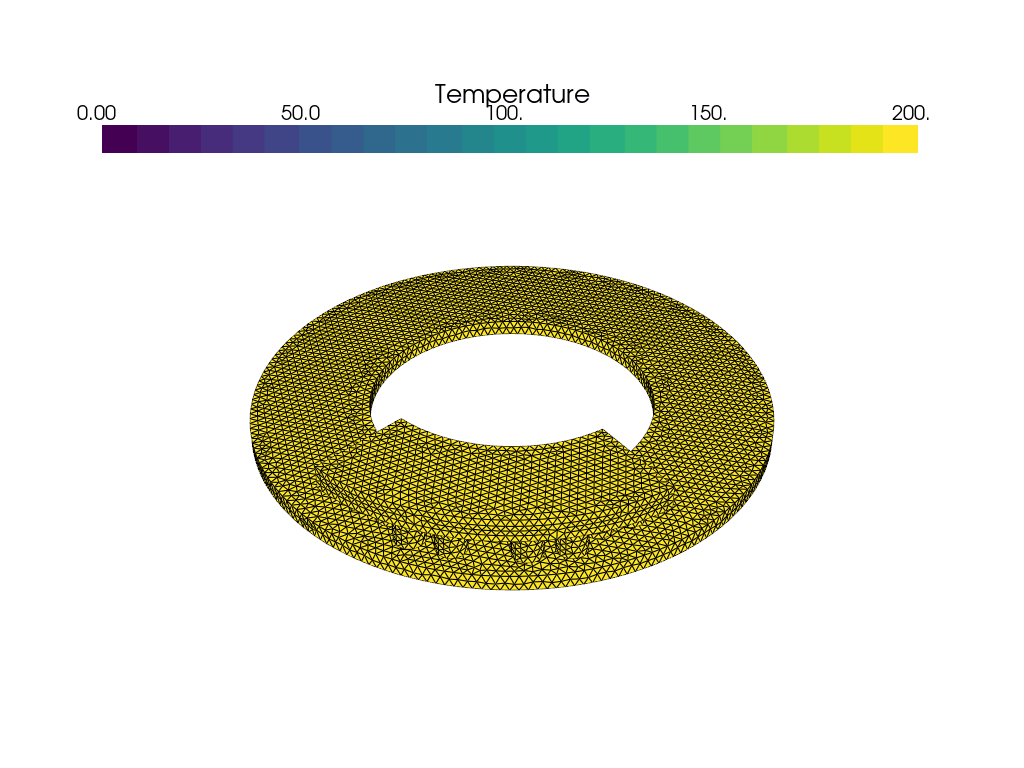

1: Start at: 2024-05-22 15:59:36
2: End at: 2024-05-22 16:10:27
3: Simulation time is 0 hours 11 minutes
4: First time step dt is 0.39741 s
5: Convection heat transfer coefficient is 7.75e-05 W/mm2 K
6: Radiation is 3.6e-13 W/mm2 K-4
7: Each rotation degree is 2200 per time step or 6.1 circle
8: The first rotation degree is 9599.3
9: The mid rotation degree is 9599.3
10: The last rotation degree is 9599.3
11: Total contact area of 18 rubbing element is 199.9 cm2
12: The mesh element size is between 3-10 mm
13: Total elements number is 43604

Move files successfully


In [8]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
              min = elapsed_time1 / 60
              hours = min / 60
              file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
              file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Project/Disc_thermal/Forward_Euler/"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results/Forward_Euler/"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
print("Move files successfully")

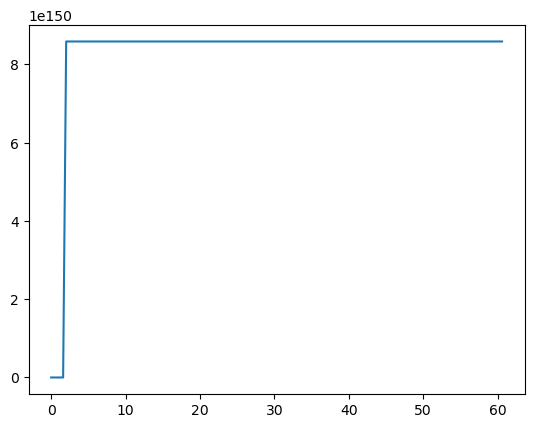

In [9]:
## get t and temperature T form T_array matrix
t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_max = []
for i in range(len(T)):
    T_max.append(max(T[i]))

plt.plot(t, T_max)

In [10]:
print(T_max)

[60, 6574.840439728196, 780249.1212002796, 7317428826947.658, 9.730702981811429e+39, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.581490746590609e+150, 8.5

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]


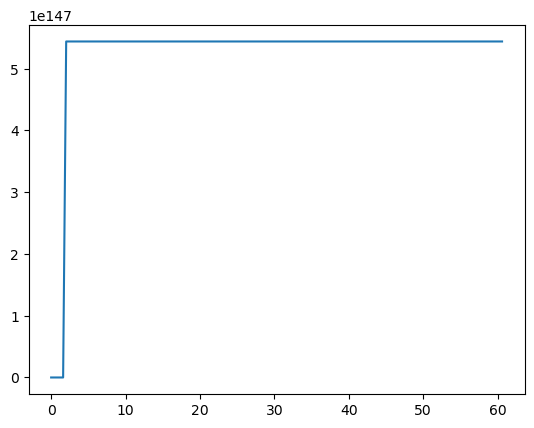

In [11]:
from brake_disc_functions import *

lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)

In [12]:
lables = find_3_coord(mesh_filename1)
# T_3_labels = 3157, 7018, 2141
# for i in range(len(T)):
#   print( T[i][T_3_labels[1]] )

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]
